In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from IPython.display import display
import pandas as pd




# Set the desired image size
img_size = (224, 224)

flpth = 'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/Train'

# Preprocess and augment the training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data_32 = train_datagen.flow_from_directory(
    #'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/sandbox/train',
    flpth,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

train_data_16 = train_datagen.flow_from_directory(
    #'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/sandbox/train',
    flpth,
    target_size=img_size,
    batch_size=16,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))



Found 3033 images belonging to 2 classes.
Found 3033 images belonging to 2 classes.


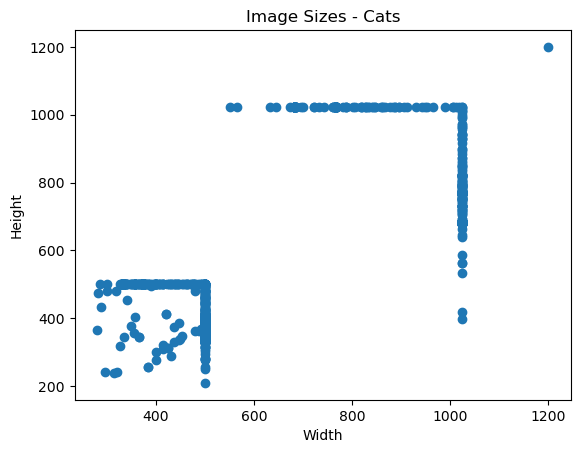

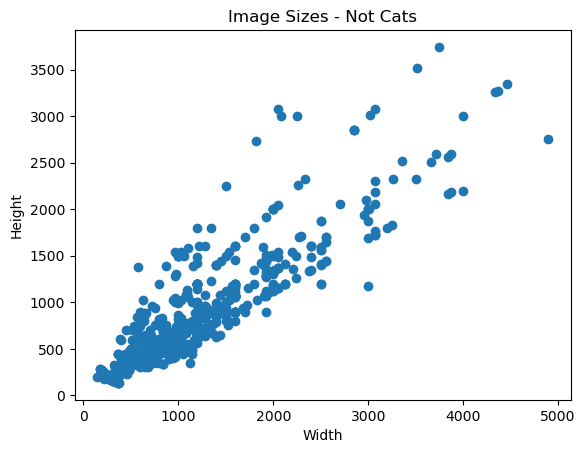

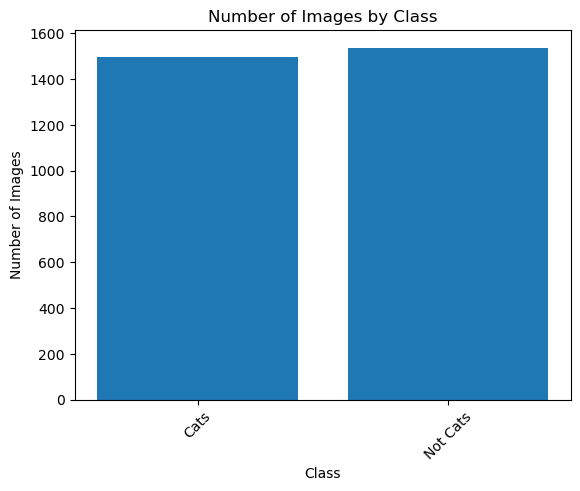

In [2]:
#EDA

#histogram of count of images by class (cat vs not cat)

# Get subfolder names and file counts
subfolders = next(os.walk(flpth))[1]
file_counts = []

for subfolder in subfolders:
    subfolder_path = os.path.join(flpth, subfolder)
    files = next(os.walk(subfolder_path))[2]
    file_count = len(files)
    file_counts.append(file_count)
    
    image_sizes = []

    # Get image sizes for each file
    for file in files:
        file_path = os.path.join(subfolder_path, file)
        image = Image.open(file_path)
        image_size = image.size
        image_sizes.append(image_size)

    # Extract width and height values
    widths, heights = zip(*image_sizes)
    # Create scatter plot
    plt.scatter(widths, heights)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f'Image Sizes - {subfolder}')
    plt.show()

# Create bar chart
plt.bar(subfolders, file_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images by Class')
plt.xticks(rotation=45)
plt.show()




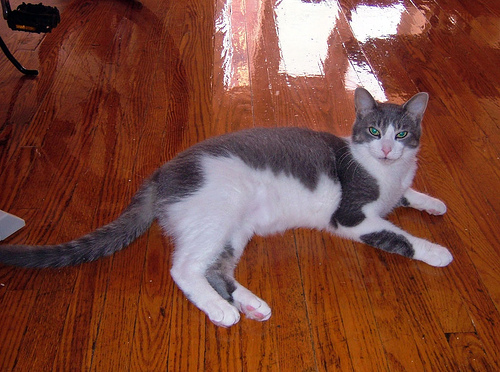

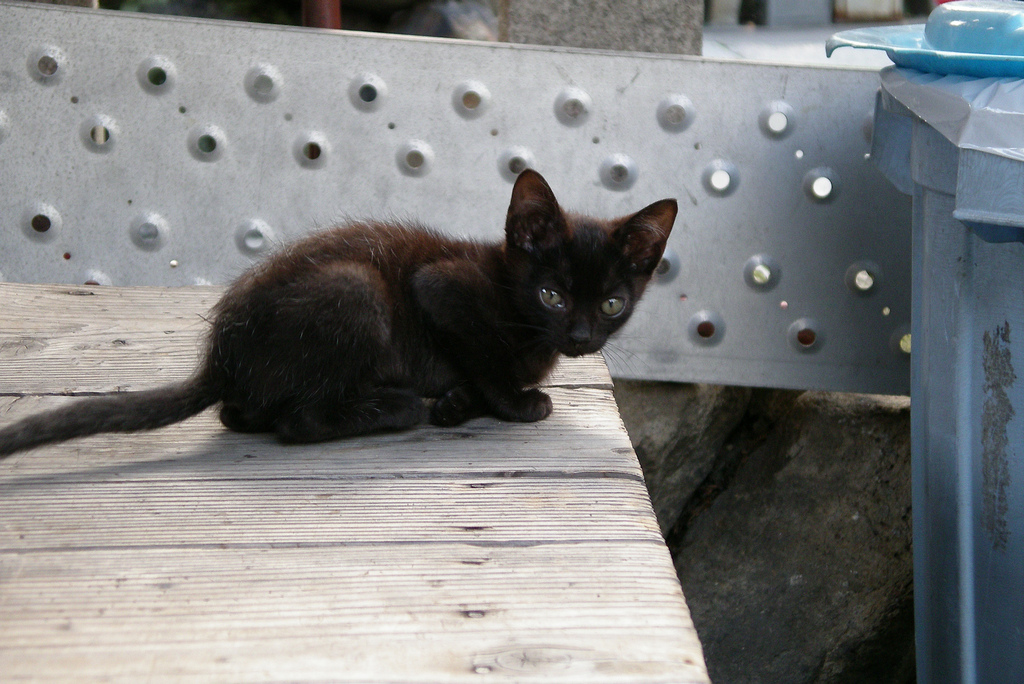

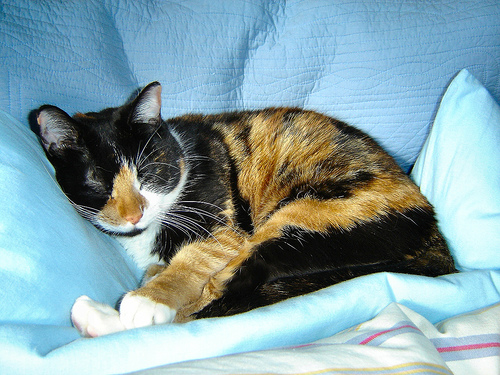

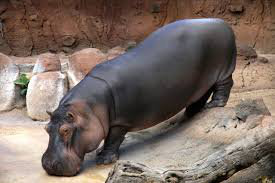

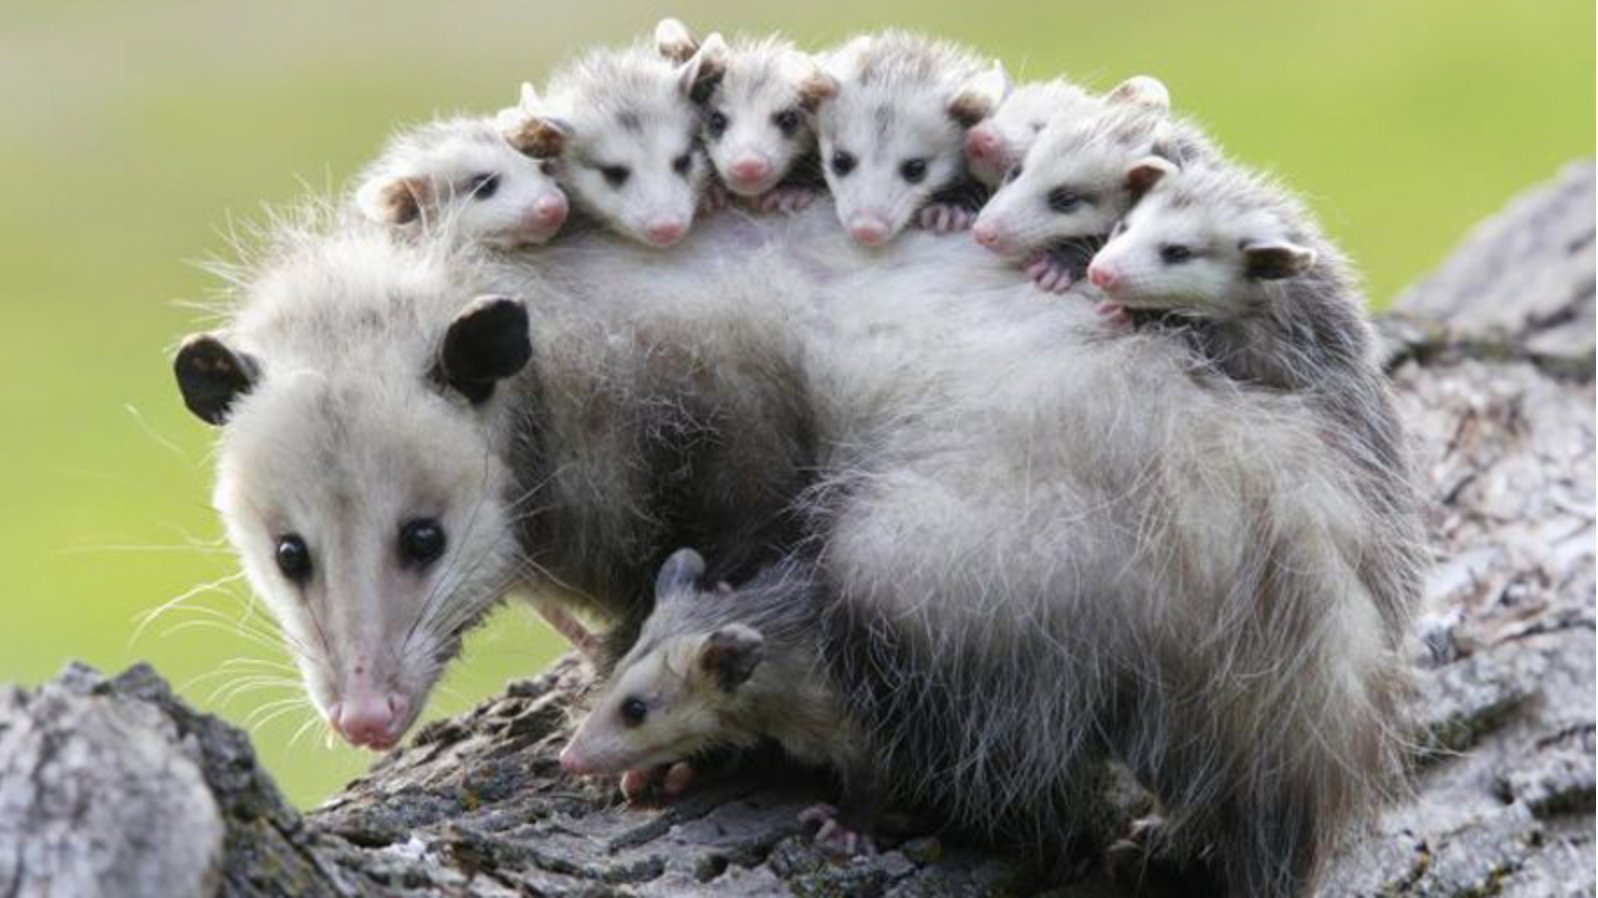

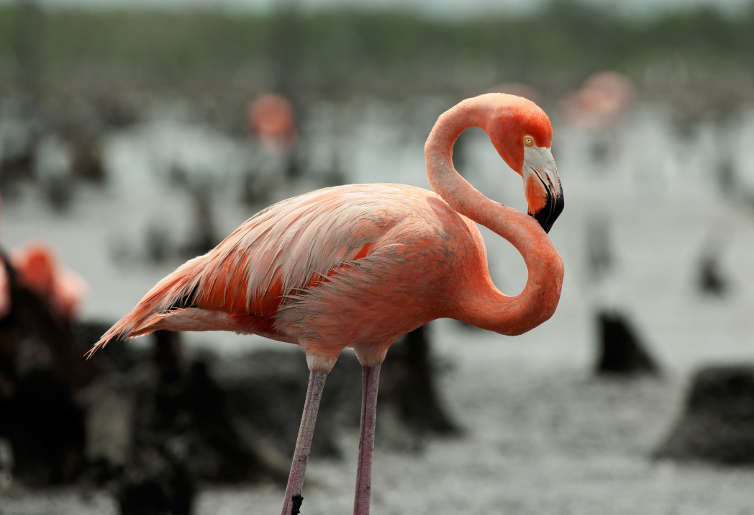

In [3]:
#sample images - include augmentations
from IPython.display import display

# Randomly select three images from each subfolder
num_images_per_subfolder = 3

for subfolder in subfolders:
    subfolder_path = os.path.join(flpth, subfolder)
    image_files = [file for file in os.listdir(subfolder_path) if file.endswith('.jpg') or file.endswith('.png')]
    selected_images = random.sample(image_files, num_images_per_subfolder)
    
    # Open and display the selected images
    for image_file in selected_images:
        image_path = os.path.join(subfolder_path, image_file)
        image = Image.open(image_path)
        display(image)



In [4]:
# Add new fully connected layers for your specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Replace num_classes with the number of cat breeds

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5_epochs_batch16 = model
model_10_epochs_batch16 = model
model_15_epochs_batch16 = model

model_5_epochs_batch32 = model
model_10_epochs_batch32 = model
model_15_epochs_batch32 = model

# Train the model
model_5_epochs_batch16.fit(train_data_16, epochs=5)

# Train the model
model_10_epochs_batch16.fit(train_data_16, epochs=10)

# Train the model
model_15_epochs_batch16.fit(train_data_16, epochs=15)

# Train the model
model_5_epochs_batch32.fit(train_data_32, epochs=5)

# Train the model
model_10_epochs_batch32.fit(train_data_32, epochs=10)

# Train the model
model_15_epochs_batch32.fit(train_data_32, epochs=15)



Epoch 1/5
190/190 [==============================] - 1034s 5s/step - loss: 1.3749 - accuracy: 0.5077
Epoch 2/5
190/190 [==============================] - 1022s 5s/step - loss: 0.6959 - accuracy: 0.4903
Epoch 3/5
190/190 [==============================] - 988s 5s/step - loss: 0.6935 - accuracy: 0.4975
Epoch 4/5
190/190 [==============================] - 968s 5s/step - loss: 0.6933 - accuracy: 0.4982
Epoch 5/5
190/190 [==============================] - 967s 5s/step - loss: 0.6932 - accuracy: 0.5008
Epoch 1/10
190/190 [==============================] - 965s 5s/step - loss: 0.6932 - accuracy: 0.4949
Epoch 2/10
190/190 [==============================] - 967s 5s/step - loss: 0.6932 - accuracy: 0.5068
Epoch 3/10
190/190 [==============================] - 967s 5s/step - loss: 0.6932 - accuracy: 0.5068
Epoch 4/10
190/190 [==============================] - 967s 5s/step - loss: 0.6933 - accuracy: 0.5068
Epoch 5/10
190/190 [==============================] - 966s 5s/step - loss: 0.6933 - accuracy: 

In [33]:
from keras.regularizers import l2

model_resize = keras.Sequential()

# Freeze the base model's layers during training
for layer in base_model.layers:
    layer.trainable = False

# Modify the receptive field size by changing the architecture

# Add layers to the model with L2 regularization
model_resize.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)))
model_resize.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_resize.add(Dense(2, activation='softmax'))
model_resize.add(layers.Reshape((224, 224, 2)))  # Add a Reshape layer to adjust the shape
model_resize.add(layers.Conv2D(128, kernel_size=(5, 5), activation='relu', input_shape=(1, 1, 2)))  # Adjust input shape here
model_resize.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Compile the model
model_resize.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resize model

train_loss_resize, train_acc_resize = model_resize.evaluate(train_data_32)

print("Train Loss: ", train_loss_resize)
print("Train Accuracy: ", train_acc_resize)


ValueError: in user code:

    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 110, 110, 128) are incompatible


In [6]:
#Base Model

train_loss, train_acc = model.evaluate(train_data_32)

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)

95/95 [==============================] - 197s 2s/step - loss: 0.6931 - accuracy: 0.5068
Train Loss:  0.6930567026138306
Train Accuracy:  0.506758987903595


In [20]:
#resize model

train_loss_resize, train_acc_resize = model_resize.evaluate(train_data_32)

print("Train Loss: ", train_loss_resize)
print("Train Accuracy: ", train_acc_resize)


ValueError: in user code:

    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 128) are incompatible


In [8]:
#batch 16 models

train_loss_5_16, train_acc_5_16 = model_5_epochs_batch16.evaluate(train_data_16)

train_loss_10_16, train_acc_10_16 = model_10_epochs_batch16.evaluate(train_data_16)

train_loss_15_16, train_acc_15_16 = model_15_epochs_batch16.evaluate(train_data_16)

print("Train Loss 5 epochs: ", train_loss_5_16)
print("Train Accuracy 5 epochs: ", train_acc_5_16)

print("Train Loss 10 epochs: ", train_loss_10_16)
print("Train Accuracy 10 epochs: ", train_acc_10_16)

print("Train Loss 15 epochs: ", train_loss_15_16)
print("Train Accuracy 15 epochs: ", train_acc_15_16)



190/190 [==============================] - 207s 1s/step - loss: 0.6931 - accuracy: 0.5068
Train Loss 5 epochs:  0.6930564641952515
Train Accuracy 5 epochs:  0.506758987903595
Train Loss 10 epochs:  0.6930568218231201
Train Accuracy 10 epochs:  0.506758987903595
Train Loss 15 epochs:  0.6930568814277649
Train Accuracy 15 epochs:  0.506758987903595


In [9]:
#batch 32 models

train_loss_5_32, train_acc_5_32 = model_5_epochs_batch32.evaluate(train_data_32)

train_loss_10_32, train_acc_10_32 = model_10_epochs_batch32.evaluate(train_data_32)

train_loss_15_32, train_acc_15_32 = model_15_epochs_batch32.evaluate(train_data_32)

print("Train Loss 5 epochs: ", train_loss_5_32)
print("Train Accuracy 5 epochs: ", train_acc_5_32)

print("Train Loss 10 epochs: ", train_loss_10_32)
print("Train Accuracy 10 epochs: ", train_acc_10_32)

print("Train Loss 15 epochs: ", train_loss_15_32)
print("Train Accuracy 15 epochs: ", train_acc_15_32)


95/95 [==============================] - 206s 2s/step - loss: 0.6931 - accuracy: 0.5068
Train Loss 5 epochs:  0.6930568814277649
Train Accuracy 5 epochs:  0.506758987903595
Train Loss 10 epochs:  0.6930568218231201
Train Accuracy 10 epochs:  0.506758987903595
Train Loss 15 epochs:  0.6930567026138306
Train Accuracy 15 epochs:  0.506758987903595


In [10]:
# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_data_16 = test_datagen.flow_from_directory(
    #'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/sandbox/test',
    'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/Test',
    target_size=img_size,
    batch_size=16,
    class_mode='categorical'
)

test_data_32 = test_datagen.flow_from_directory(
    #'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/sandbox/test',
    'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/Test',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)



Found 4882 images belonging to 2 classes.
Found 4882 images belonging to 2 classes.


In [11]:
test_loss, test_acc = model.evaluate(test_data_32)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)



153/153 [==============================] - 350s 2s/step - loss: 0.6962 - accuracy: 0.3771
Test Loss:  0.6961855888366699
Test Accuracy:  0.37709954380989075
153/153 [==============================] - 326s 2s/step - loss: 0.6962 - accuracy: 0.3771
Test Loss:  0.6961854100227356
Test Accuracy:  0.37709954380989075


In [26]:
#resize model

test_loss_resize, test_acc_resize = model_resize.evaluate(test_data_32)

print("Test Loss: ", test_loss_resize)
print("Test Accuracy: ", test_acc_resize)

ValueError: in user code:

    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\justj\anaconda3\lib\site-packages\keras\backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, None, None, 128) are incompatible


In [12]:
#batch 16 models

test_loss_5_16, test_acc_5_16 = model_5_epochs_batch16.evaluate(test_data_16)

test_loss_10_16, test_acc_10_16 = model_10_epochs_batch16.evaluate(test_data_16)

test_loss_15_16, test_acc_15_16 = model_15_epochs_batch16.evaluate(test_data_16)

print("Test Loss 5 epochs: ", test_loss_5_16)
print("Test Accuracy 5 epochs: ", test_acc_5_16)

print("Test Loss 10 epochs: ", test_loss_10_16)
print("Test Accuracy 10 epochs: ", test_acc_10_16)

print("Test Loss 15 epochs: ", test_loss_15_16)
print("Test Accuracy 15 epochs: ", test_acc_15_16)

306/306 [==============================] - 329s 1s/step - loss: 0.6962 - accuracy: 0.3771
Test Loss 5 epochs:  0.6961857080459595
Test Accuracy 5 epochs:  0.37709954380989075
Test Loss 10 epochs:  0.6961861848831177
Test Accuracy 10 epochs:  0.37709954380989075
Test Loss 15 epochs:  0.6961857676506042
Test Accuracy 15 epochs:  0.37709954380989075


In [13]:
#batch 32 models

test_loss_5_32, test_acc_5_32 = model_5_epochs_batch32.evaluate(test_data_32)

test_loss_10_32, test_acc_10_32 = model_10_epochs_batch32.evaluate(test_data_32)

test_loss_15_32, test_acc_15_32 = model_15_epochs_batch32.evaluate(test_data_32)

print("Test Loss 5 epochs: ", test_loss_5_32)
print("Test Accuracy 5 epochs: ", test_acc_5_32)

print("Test Loss 10 epochs: ", test_loss_10_32)
print("Test Accuracy 10 epochs: ", test_acc_10_32)

print("Test Loss 15 epochs: ", test_loss_15_32)
print("Test Accuracy 15 epochs: ", test_acc_15_32)

153/153 [==============================] - 327s 2s/step - loss: 0.6962 - accuracy: 0.3771
Test Loss 5 epochs:  0.6961857080459595
Test Accuracy 5 epochs:  0.37709954380989075
Test Loss 10 epochs:  0.6961855292320251
Test Accuracy 10 epochs:  0.37709954380989075
Test Loss 15 epochs:  0.6961855888366699
Test Accuracy 15 epochs:  0.37709954380989075


In [14]:

# Set the path to the test data folder
#test_data_folder = 'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/Test/animal_images/animal_images'

# Set the path to the spreadsheet containing species names and image names
#spreadsheet_path = 'C:/Users/justj/MSCA 31009/Cat Image Recognition/Data/Test/animal_data_img.csv'

# Load the spreadsheet data into a pandas DataFrame
#spreadsheet_data = pd.read_csv(spreadsheet_path)

# Rename the 'Image_File' column to 'Image Name'
#spreadsheet_data = spreadsheet_data.rename(columns={'Image_File': 'Image Name'})

# Create an empty DataFrame to store the predictions
#predictions_df = pd.DataFrame(columns=['Image Name', 'Prediction'], dtype=bool)

# Iterate over the test data images
#for image_name in os.listdir(test_data_folder):
 #   image_path = os.path.join(test_data_folder, image_name)
    
    # Load and preprocess the image
  #  image = load_img(image_path, target_size=(224, 224))
   # image_array = img_to_array(image)
    #image_array = image_array / 255.0  # Normalize the image
    
    # Reshape the image array to match the expected input shape of the model
    #image_array = tf.expand_dims(image_array, axis=0)
    
    # Make a prediction using your trained model
   # prediction = model.predict(image_array)
    #is_cat = prediction.argmax() == 0
    
    # Append the image name and prediction to the DataFrame
    #predictions_df = pd.concat([predictions_df, pd.DataFrame({'Image Name': ['animal_images/' + image_name], 'Prediction': [is_cat]})], ignore_index=True)

# Merge the predictions DataFrame with the spreadsheet data based on the image name
#merged_df = pd.merge(predictions_df, spreadsheet_data, on='Image Name')

# Display the final table
#print(merged_df)



In [15]:
#merged_df['IsCat'] = merged_df['Animal_Type'] == 'Cat'

#true_true_count = ((merged_df['Prediction'] == True) & (merged_df['IsCat'] == True)).sum()
#true_false_count = ((merged_df['Prediction'] == True) & (merged_df['IsCat'] == False)).sum()
#false_true_count = ((merged_df['Prediction'] == False) & (merged_df['IsCat'] == True)).sum()
#false_false_count = ((merged_df['Prediction'] == False) & (merged_df['IsCat'] == False)).sum()

#print("True-True count:", true_true_count)
#print("True-False count:", true_false_count)
#print("False-True count:", false_true_count)
#print("False-False count:", false_false_count)


In [16]:
# Make predictions on new images
new_image = tf.keras.preprocessing.image.load_img('C:/Users/justj/MSCA 31009/Cat Image Recognition/chloe.jpg', target_size=img_size)
new_image = tf.keras.preprocessing.image.img_to_array(new_image)
new_image = new_image / 255.0  # Normalize the image
new_image = tf.expand_dims(new_image, axis=0)

predictions = model.predict(new_image)
if np.argmax(predictions) == 0:
    is_cat = True
else:
    is_cat = False
#is_cat = bool(tf.argmax(predictions, axis=1)[0])  # Convert the predicted class index to a boolean: True if cat, False if not cat

if is_cat:
    print("The image is of a cat.")
else:
    print("The image is not of a cat.")


1/1 [==============================] - 0s 223ms/step
The image is not of a cat.


In [17]:
# Make predictions on new images
new_image = tf.keras.preprocessing.image.load_img('C:/Users/justj/MSCA 31009/Cat Image Recognition/lebron.jpg', target_size=img_size)
new_image = tf.keras.preprocessing.image.img_to_array(new_image)
new_image = new_image / 255.0  # Normalize the image
new_image = tf.expand_dims(new_image, axis=0)

predictions = model.predict(new_image)
if np.argmax(predictions) == 0:
    is_cat = True
else:
    is_cat = False
#is_cat = bool(tf.argmax(predictions, axis=1)[0])  # Convert the predicted class index to a boolean: True if cat, False if not cat

if is_cat:
    print("The image is of a cat.")
else:
    print("The image is not of a cat.")

1/1 [==============================] - 0s 92ms/step
The image is not of a cat.


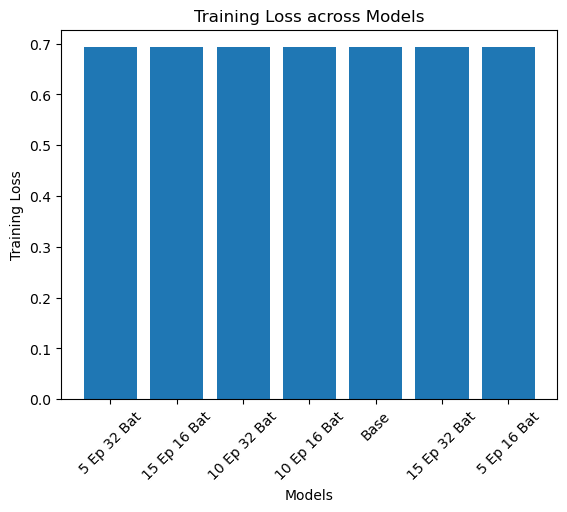

[0.6930567026138306, 0.6930564641952515, 0.6930568218231201, 0.6930568814277649, 0.6930568814277649, 0.6930568218231201, 0.6930567026138306]


In [45]:
import matplotlib.pyplot as plt

labels = ['Base', '5 Ep 16 Bat', '10 Ep 16 Bat', '15 Ep 16 Bat', '5 Ep 32 Bat', '10 Ep 32 Bat', '15 Ep 32 Bat']
values = [train_loss, train_loss_5_16, train_loss_10_16, train_loss_15_16,train_loss_5_32,train_loss_10_32,train_loss_15_32]

# Sort the values in descending order
sorted_data = sorted(zip(values, labels), reverse=True)

sorted_labels = [label for _, label in sorted_data]
sorted_values = [value for value, _ in sorted_data]

# Create the bar chart
plt.bar(sorted_labels, sorted_values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Training Loss')
plt.title('Training Loss across Models')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.show()

print(values)



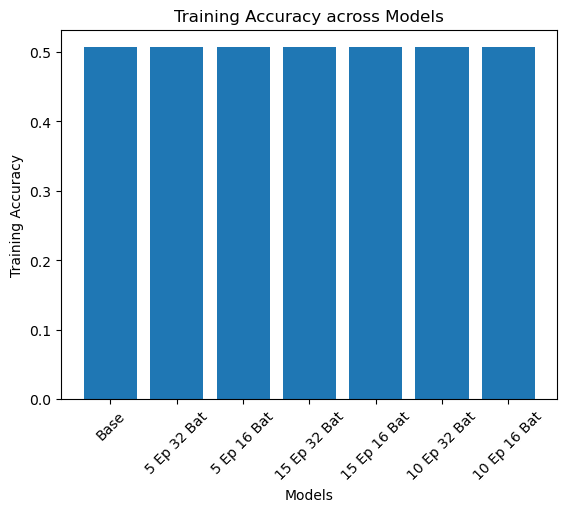

[0.506758987903595, 0.506758987903595, 0.506758987903595, 0.506758987903595, 0.506758987903595, 0.506758987903595, 0.506758987903595]


In [46]:
values = [train_acc, train_acc_5_16, train_acc_10_16, train_acc_15_16,train_acc_5_32,train_acc_10_32,train_acc_15_32]

# Sort the values in descending order
sorted_data = sorted(zip(values, labels), reverse=True)

sorted_labels = [label for _, label in sorted_data]
sorted_values = [value for value, _ in sorted_data]

# Create the bar chart
plt.bar(sorted_labels, sorted_values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy across Models')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.show()
print(values)

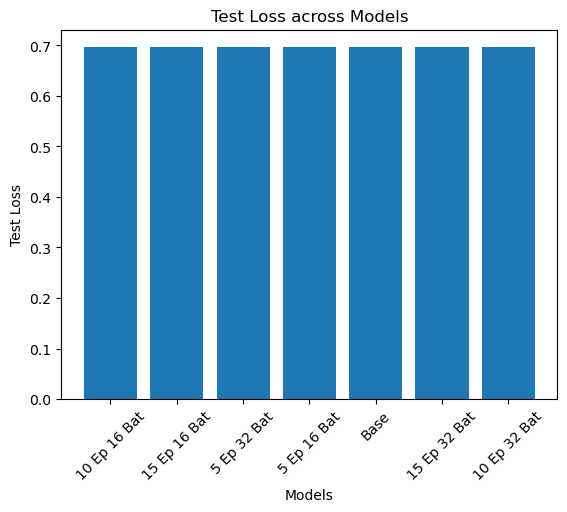

[0.6961855888366699, 0.6961857080459595, 0.6961861848831177, 0.6961857676506042, 0.6961857080459595, 0.6961855292320251, 0.6961855888366699]


In [47]:
values = [test_loss, test_loss_5_16, test_loss_10_16, test_loss_15_16,test_loss_5_32,test_loss_10_32,test_loss_15_32]

# Sort the values in descending order
sorted_data = sorted(zip(values, labels), reverse=True)

sorted_labels = [label for _, label in sorted_data]
sorted_values = [value for value, _ in sorted_data]

# Create the bar chart
plt.bar(sorted_labels, sorted_values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Test Loss')
plt.title('Test Loss across Models')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.show()
print(values)

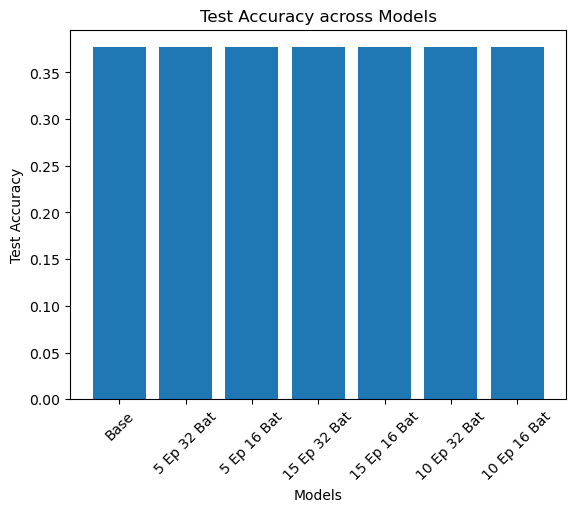

[0.37709954380989075, 0.37709954380989075, 0.37709954380989075, 0.37709954380989075, 0.37709954380989075, 0.37709954380989075, 0.37709954380989075]


In [48]:
values = [test_acc, test_acc_5_16, test_acc_10_16, test_acc_15_16,test_acc_5_32,test_acc_10_32,test_acc_15_32]

# Sort the values in descending order
sorted_data = sorted(zip(values, labels), reverse=True)

sorted_labels = [label for _, label in sorted_data]
sorted_values = [value for value, _ in sorted_data]

# Create the bar chart
plt.bar(sorted_labels, sorted_values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy across Models')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.show()
print(values)

In [36]:
train_loss_5_16, train_acc_5_16,train_loss_10_16
train_acc_10_16,train_loss_15_16, train_acc_15_16,train_loss_5_32, train_acc_5_32, train_loss_10_32, train_acc_10_32
train_loss_15_32, train_acc_15_32

(0.6930567026138306, 0.506758987903595)